## 使用线性判别分析（LDA）在鸢尾花数据集上进行数据规约

In [1]:
# 导入鸢尾花数据集
from sklearn.datasets import load_iris

In [17]:
# 导入一些必要的库
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 加载数据集
iris = load_iris()
# 分别存储数据集的行（样本）和列（特征）
iris_X, iris_Y = iris.data, iris.target

In [4]:
# 查看数据的size
iris_X.shape, iris_Y.shape

((150, 4), (150,))

In [5]:
# 查看数据的类别
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
# 查看数据的特征
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
# 将类别名与标签一一映射
label_dict = {i:k for i,k in enumerate(iris.target_names)}

In [8]:
# 查看映射
label_dict

{0: np.str_('setosa'), 1: np.str_('versicolor'), 2: np.str_('virginica')}

### LDA大致分为以下五个步骤
1. 计算每个类别的均值向量；
2. 计算类内和类间的散布矩阵；
3. 计算 $S_W^{-1}$·$S_B$的特征值和特征向量；
4. 降序排列特征值，保留前k个特征向量；
5. 使用前几个特征向量将数据投影到新空间。

#### 1. 计算每个类别的均值向量

In [9]:
mean_vectors = []
for cls in [0, 1, 2]:
    class_mean_vector = np.mean(iris_X[iris_Y==cls],axis=0)
    mean_vectors.append(class_mean_vector)
    print(label_dict[cls], class_mean_vector)


setosa [5.006 3.428 1.462 0.246]
versicolor [5.936 2.77  4.26  1.326]
virginica [6.588 2.974 5.552 2.026]


#### 2. 计算类内和类间的散布矩阵

类内散布矩阵，定义如下：
                    $S_W$ = $\sum_{i=1}^c$ $S_i$

$S_i$的定义是：
                    $S_i$ = $\sum_{x\in D_i}^n$ $(x - m_i)(x-m_i)^T$

其中，$m_i$代表第 $i$ 个类别的均值向量。

类间散布矩阵的定义是：
                    $S_B$ = $\sum_{i=1}^c$ $N_i(m_i-m)(m_i-m)^T$


$m$是数据集的总体均值，$m_i$是每个类别的样本均值，$N_i$是每个类别的样本大小（观察值数量）

In [10]:
# 类内散布矩阵
S_W = np.zeros((4,4))
for cls, mv in zip(range(3), mean_vectors):
    S_cls = np.zeros((4,4))
    for row in iris_X[iris_Y == cls]:
        row, mv = row.reshape(4,1), mv.reshape(4,1)
        S_cls += (row-mv).dot((row-mv).T)
    S_W += S_cls

print(S_W)

[[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


In [11]:
# 类间散布矩阵
all_mean = np.mean(iris_X, axis=0).reshape(4,1)
S_B = np.zeros((4,4))
for cls, mv in zip(range(3), mean_vectors):
    mv = mv.reshape(4,1)
    S_B += len(iris_X[iris_Y == cls])*(mv-all_mean).dot((mv-all_mean).T)

print(S_B)

[[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


#### 3. 计算 $S_W^{-1}$·$S_B$的特征值和特征向量；

In [29]:
eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))
eig_vals = eig_vals.real
eig_vecs = eig_vecs.real
for i in range(len(eig_vals)):
    eig_vec_cls = eig_vecs[:,i]
    print('特征向量 {}: {}'.format(i+1, eig_vec_cls))
    print('特征值 {}: {}'.format(i+1, eig_vals[i]))

特征向量 1: [-0.20874182 -0.38620369  0.55401172  0.7073504 ]
特征值 1: 32.191929198278025
特征向量 2: [-0.00653196 -0.58661055  0.25256154 -0.76945309]
特征值 2: 0.28539104262306647
特征向量 3: [-0.14156417 -0.212536   -0.27030318  0.69269842]
特征值 3: -2.8907453147977534e-15
特征向量 4: [-0.14156417 -0.212536   -0.27030318  0.69269842]
特征值 4: -2.8907453147977534e-15


注意第三个和第四个特征值几乎是 0，这是因为 LDA 的工作方式是在类间划分决策边界。

#### 4. 降序排列特征值，保留前k个特征向量

因为LDA的工作方式是在类间划分决策边界。考虑到鸢尾花数据中只有 3 个类别，我们可能只需要 2 个决策边界。通常来说，用 LDA拟合 n 个类别的数据集，最多只需要 n-1 次切割。

In [30]:
# 保留最有用的特征向量
linear_discriminants = eig_vecs.T[:2]

linear_discriminants

array([[-0.20874182, -0.38620369,  0.55401172,  0.7073504 ],
       [-0.00653196, -0.58661055,  0.25256154, -0.76945309]])

用每个特征值除以特征值的和，可以查看每个类别（线性判别式）解释总方差的比例：

In [31]:
eig_vals / eig_vals.sum()

array([ 9.91212605e-01,  8.78739503e-03, -8.90081230e-17, -8.90081230e-17])

可以看到第一个判别式所占比例最大，拥有超过99％的信息

#### 使用前几个特征向量投影到新空间

现在我们有了所有的线性判别式，先用特征向量将鸢尾花数据集投影到新空间，然后用 plot
函数绘制投影数据

In [42]:
# 定义一个画图函数
def plot(X, y, title, x_label, y_label):
  ax = plt.subplot(111)
  for label,marker,color in zip(range(3),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(x=X[:,0].real[y == label], y=X[:,1].real[y == label], color=color, alpha=0.5, label=label_dict[label] )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
  leg = plt.legend(loc='upper right', fancybox=True)
  leg.get_frame().set_alpha(0.5)
  plt.title(title)

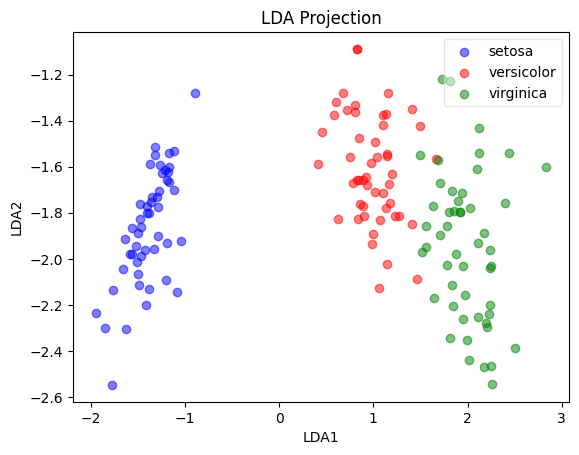

In [41]:
# LDA投影数据
lda_iris_projection = np.dot(iris_X, linear_discriminants.T)
lda_iris_projection[:5,]

plot(lda_iris_projection, iris_Y, 'LDA Projection', 'LDA1', 'LDA2')

可以看到在图中不同类别的数据几乎完全分离开了，
因为 LDA 会绘制决策边界，提供特征向量/线性判别式，从而帮助机器学习模型尽可能分离各种花。这有助于将数据投影到每个类别都尽可能分散的空间中。

## 使用scikit-learn库中的LDA算法在鸢尾花数据集上进行分类任务

在上面，我们人工实现了 LDA 算法的核心部分，而其实在 sklearn 库中已经帮我们实现好了，下面我会使用库中的函数在之前提到的鸢尾花数据集上完成一个简单的分类任务

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

我们用K最近邻（KNN）作为有监督模型，用流水线模块将KNN模型和特征转换工具结合
起来，创建一个可以使用 cross_val_score 模块进行交叉验证的机器学习流水线。

In [59]:
# 创建有一个判别式的 LDA 模块
lda_one = LinearDiscriminantAnalysis(n_components=1)
# 实例化 KNN 模型
knn = KNeighborsClassifier(n_neighbors=3)


不用做任何转换，调用KNN模型，来取一个基线准确率。我们将用它来对比LDA究竟对模型有何提升

In [60]:
# 不用特征转换，用 KNN 进行交叉验证
knn_average = cross_val_score(knn, iris_X, iris_Y).mean()
# 这是基线准确率。如果什么也不做，KNN 的准确率是 96.7%
knn_average

np.float64(0.9666666666666668)

knn的基线准确率为96.7％，我们使用LDA，只保留其中最好的线性判别式

In [61]:
lda_pipeline = Pipeline([('lda',lda_one), ('knn',knn)])
lda_average = cross_val_score(lda_pipeline, iris_X, iris_Y).mean()

lda_average

np.float64(0.9666666666666666)

可以看到当使用一个线性判别式时，精度反而不如原始的knn模型，因此我们试试用两个判别式的LDA会有如何表现

In [62]:
lda_two = LinearDiscriminantAnalysis(n_components=2)
lda_pipeline2 = Pipeline([('lda',lda_two),('knn',knn)])

lda_average2 = cross_val_score(lda_pipeline2, iris_X, iris_Y).mean()

lda_average2

np.float64(0.9733333333333334)

可以发现当判别式变为2时，精度确实上升了，证明LDA算法确实在特征变换时是有用的。